# Boost revenue

I am an analyst at a big online store. Together with the marketing department, I have compiled a list of hypotheses that may help boost revenue.  
I need to prioritize these hypotheses, launch an A/B test, and analyze the results.

To do so, I have to:
1. Inspect the data for any impurities, missing values,parameters that need to be changed.
1. Fix the problems with the data.
1. Prioritize hypotheses.
1. Analyze the A/B test for the hypotheses.

In [135]:
import pandas as pd                                           
import numpy as np
import datetime as dt 
import matplotlib.pyplot as plt
from scipy import stats as st
import seaborn as sns
import plotly.express as px

In [136]:
try:
    hypotheses_df = pd.read_csv('hypotheses_us.csv')
except:
    hypotheses_df = pd.read_csv('/datasets/hypotheses_us.csv')

try:
    orders_df = pd.read_csv('orders_us.csv')
except:
    orders_df = pd.read_csv('/datasets/orders_us.csv')
    
try:
    visits_df = pd.read_csv('visits_us.csv')
except:
    visits_df = pd.read_csv('/datasets/visits_us.csv')

# Pre-process the data

## Data inspection

First, using the info() method, will check if the columns contain missing values, if there are data types that need to change, and if generally there is something strange in the data.

In [137]:
print(hypotheses_df.info())
print(orders_df.info())
visits_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 1 columns):
 #   Column                                     Non-Null Count  Dtype 
---  ------                                     --------------  ----- 
 0   Hypothesis;Reach;Impact;Confidence;Effort  9 non-null      object
dtypes: object(1)
memory usage: 200.0+ bytes
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   transactionId  1197 non-null   int64  
 1   visitorId      1197 non-null   int64  
 2   date           1197 non-null   object 
 3   revenue        1197 non-null   float64
 4   group          1197 non-null   object 
dtypes: float64(1), int64(2), object(2)
memory usage: 46.9+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  ----

In the hypothesis columns I don't really get what I am seeing.  
In the orders columns the date column needs to be changed to datetime, and I think I can change the group column to category.  
In the visits columns, the same thing as in the orders table.

To understand the data better, I will print the rows of the tables.

In [138]:
hypotheses_df.head(10)

,Hypothesis;Reach;Impact;Confidence;Effort
0,Add two new channels for attracting traffic. This will bring 30% more users;3;10;8;6
1,Launch your own delivery service. This will shorten delivery time;2;5;4;10
2,Add product recommendation blocks to the store's site. This will increase conversion and average purchase size;8;3;7;3
3,Change the category structure. This will increase conversion since users will find the products they want more quickly;8;3;3;8
4,Change the background color on the main page. This will increase user engagement;3;1;1;1
5,Add a customer review page. This will increase the number of orders;3;2;2;3
6,Show banners with current offers and sales on the main page. This will boost conversion;5;3;8;3
7,Add a subscription form to all the main pages. This will help you compile a mailing list;10;7;8;5
8,Launch a promotion that gives users discounts on their birthdays;1;9;9;5


In [139]:
hypotheses_df['Hypothesis;Reach;Impact;Confidence;Effort'][0]

'Add two new channels for attracting traffic. This will bring 30% more users;3;10;8;6'

Seems like all the columns in hypothesis table are merged together.  
It also seems that the columns contain upper case letters.

In [140]:
orders_df.head(10)

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,30.4,B
1,2804400009,3642806036,2019-08-15,15.2,B
2,2961555356,4069496402,2019-08-15,10.2,A
3,3797467345,1196621759,2019-08-15,155.1,B
4,2282983706,2322279887,2019-08-15,40.5,B
5,182168103,935554773,2019-08-15,35.0,B
6,398296753,2900797465,2019-08-15,30.6,B
7,2626614568,78758296,2019-08-15,20.1,A
8,1576988021,295230930,2019-08-15,215.9,A
9,1506739906,1882260405,2019-08-15,30.5,B


In [141]:
visits_df.head(10)

,date,group,visits
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756
5,2019-08-06,A,667
6,2019-08-07,A,644
7,2019-08-08,A,610
8,2019-08-09,A,617
9,2019-08-10,A,406


Don't really see something out of the ordinary in orders and visits.  
Lets see if some of the orders have 0 in revenue.

In [142]:
orders_df[orders_df['revenue'] == 0]

,transactionId,visitorId,date,revenue,group


Seems that every order got payed for.  
Lets check for duplicates in the orders and visitors tables.

In [143]:
visits_df[visits_df.duplicated()]

,date,group,visits


In [144]:
orders_df[orders_df.duplicated()]

,transactionId,visitorId,date,revenue,group


The data is clean from duplicates.  
For the last one lets check if there are customers that appear in both groups.  
To do that, I'll create a table that groups the number of unique groups by visitorsId.  
Then I'll see if there are rows that contain two groups. 

In [145]:
orders_df['group'].value_counts()

B    640
A    557
Name: group, dtype: int64

In [146]:
two_gorups_check = orders_df.groupby('visitorId', as_index = False).agg({'group':'nunique'})
two_gorups_check[two_gorups_check['group'] == 2]

,visitorId,group
2,8300375,2
44,199603092,2
51,232979603,2
55,237748145,2
66,276558944,2
84,351125977,2
97,393266494,2
114,457167155,2
119,471551937,2
122,477780734,2


Seems like there are customers that are in both groups. I will have to remove them.

### Midway conclusion

1. The date and group columns in the orders and visitors tables need to have their data type changed.
1. The hypothesis table needs to split its columns and data.
1. The hypothesis table contains upper case letters, I'll change them to lower case.
1. And there are users that are in groups A and B, they need to be deleted.

## Data correction

### Changing data type

First I will change the data type of the date column, in both orders and visits tables, to datetime. 

In [147]:
orders_df['date'] = orders_df['date'].map(lambda x: dt.datetime.strptime(x, '%Y-%m-%d'))
visits_df['date'] = visits_df['date'].map(lambda x: dt.datetime.strptime(x, '%Y-%m-%d'))

Now I will change the group data type in to categories.

In [148]:
orders_df['group'] = orders_df['group'].astype('category')
visits_df['group'] = visits_df['group'].astype('category')
orders_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   transactionId  1197 non-null   int64         
 1   visitorId      1197 non-null   int64         
 2   date           1197 non-null   datetime64[ns]
 3   revenue        1197 non-null   float64       
 4   group          1197 non-null   category      
dtypes: category(1), datetime64[ns](1), float64(1), int64(2)
memory usage: 38.8 KB


In [149]:
visits_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    62 non-null     datetime64[ns]
 1   group   62 non-null     category      
 2   visits  62 non-null     int64         
dtypes: category(1), datetime64[ns](1), int64(1)
memory usage: 1.3 KB


### Split the data

Using the sep in the read_csv(), I can separate the columns the hypothesis table in to a readable format.

In [150]:
try:
    hypotheses_df = pd.read_csv('hypotheses_us.csv', sep = ';')
except:
    hypotheses_df = pd.read_csv('/datasets/hypotheses_us.csv', sep = ';')
    
pd.set_option('display.max_colwidth', None)   
    
hypotheses_df

,Hypothesis,Reach,Impact,Confidence,Effort
0,Add two new channels for attracting traffic. This will bring 30% more users,3,10,8,6
1,Launch your own delivery service. This will shorten delivery time,2,5,4,10
2,Add product recommendation blocks to the store's site. This will increase conversion and average purchase size,8,3,7,3
3,Change the category structure. This will increase conversion since users will find the products they want more quickly,8,3,3,8
4,Change the background color on the main page. This will increase user engagement,3,1,1,1
5,Add a customer review page. This will increase the number of orders,3,2,2,3
6,Show banners with current offers and sales on the main page. This will boost conversion,5,3,8,3
7,Add a subscription form to all the main pages. This will help you compile a mailing list,10,7,8,5
8,Launch a promotion that gives users discounts on their birthdays,1,9,9,5


### Lower case

Now I'll change the columns names to lower case using columns.str.lower() 

In [151]:
hypotheses_df.columns = hypotheses_df.columns.str.lower()
hypotheses_df

,hypothesis,reach,impact,confidence,effort
0,Add two new channels for attracting traffic. This will bring 30% more users,3,10,8,6
1,Launch your own delivery service. This will shorten delivery time,2,5,4,10
2,Add product recommendation blocks to the store's site. This will increase conversion and average purchase size,8,3,7,3
3,Change the category structure. This will increase conversion since users will find the products they want more quickly,8,3,3,8
4,Change the background color on the main page. This will increase user engagement,3,1,1,1
5,Add a customer review page. This will increase the number of orders,3,2,2,3
6,Show banners with current offers and sales on the main page. This will boost conversion,5,3,8,3
7,Add a subscription form to all the main pages. This will help you compile a mailing list,10,7,8,5
8,Launch a promotion that gives users discounts on their birthdays,1,9,9,5


### Deleting mistakes

In order to delete the users that are in both groups, I'll have to divide the orders_df table in to 2 tables for each group.  
After that, I will merge the tables in to one using inner merge on visitorId. That way, I'll get a table containing just the data of the users in both groups.  
From here, I can cerate a list that contains all the visitorIds that appear in both groups.  
then by saying that the original data is equal to the data without the people in the list, we can get rid of all the users how appear in both groups. 

In [152]:
df_order_a = orders_df[orders_df['group'] == 'A']
df_order_b = orders_df[orders_df['group'] == 'B']

orders_all_groups = pd.merge(df_order_a,df_order_b, on = 'visitorId', how = 'inner')

two_group_users = orders_all_groups['visitorId']

orders_df = orders_df[~orders_df['visitorId'].isin(two_group_users)]

Lets check that it worked

In [153]:
 orders_df[orders_df['visitorId'].isin(two_group_users)]

,transactionId,visitorId,date,revenue,group


Looks good

### Midway conclusion

1. I changed the data type of the group column to category, and the date column to date time,  
   in both orders_df table and visits_df table.
1. I separated the data in hypothesis_df table to distinct columns.
1. Changed the made all letters in the columns of the hypothesis table to lower case.
1. Deleted all the visitorIds that were in more then two groups in the orders table. 

# Prioritizing hypotheses

Using the RICE and ICE methods, I'll try to prioritize the hypotheses

## ICE

To create a ICE column in the hypothesis table, I need to multiply impact with confidence, and divide the result by efforts. 

In [154]:
hypotheses_df['ice'] = (hypotheses_df['impact'] * hypotheses_df['confidence']) / hypotheses_df['effort']
hypotheses_df = hypotheses_df.sort_values(by = 'ice', ascending = False)
hypotheses_df

,hypothesis,reach,impact,confidence,effort,ice
8,Launch a promotion that gives users discounts on their birthdays,1,9,9,5,16.200000
0,Add two new channels for attracting traffic. This will bring 30% more users,3,10,8,6,13.333333
7,Add a subscription form to all the main pages. This will help you compile a mailing list,10,7,8,5,11.200000
6,Show banners with current offers and sales on the main page. This will boost conversion,5,3,8,3,8.000000
2,Add product recommendation blocks to the store's site. This will increase conversion and average purchase size,8,3,7,3,7.000000
1,Launch your own delivery service. This will shorten delivery time,2,5,4,10,2.000000
5,Add a customer review page. This will increase the number of orders,3,2,2,3,1.333333
3,Change the category structure. This will increase conversion since users will find the products they want more quickly,8,3,3,8,1.125000
4,Change the background color on the main page. This will increase user engagement,3,1,1,1,1.000000


8 seems like the best hypothesis by the ICE metric.  
After 8 it's 0, 7, 6 and 2.  
Lets see if something changes when using the RICE method. 

## RICE

To find the RICE of a hypothesis, is the same as finding the ICE,  
the difference is that we also multiply the ICE with reach column.

In [155]:
hypotheses_df['rice'] = hypotheses_df['ice'] * hypotheses_df['reach']
hypotheses_df = hypotheses_df.sort_values(by = 'rice', ascending = False)
hypotheses_df

,hypothesis,reach,impact,confidence,effort,ice,rice
7,Add a subscription form to all the main pages. This will help you compile a mailing list,10,7,8,5,11.200000,112.0
2,Add product recommendation blocks to the store's site. This will increase conversion and average purchase size,8,3,7,3,7.000000,56.0
0,Add two new channels for attracting traffic. This will bring 30% more users,3,10,8,6,13.333333,40.0
6,Show banners with current offers and sales on the main page. This will boost conversion,5,3,8,3,8.000000,40.0
8,Launch a promotion that gives users discounts on their birthdays,1,9,9,5,16.200000,16.2
3,Change the category structure. This will increase conversion since users will find the products they want more quickly,8,3,3,8,1.125000,9.0
1,Launch your own delivery service. This will shorten delivery time,2,5,4,10,2.000000,4.0
5,Add a customer review page. This will increase the number of orders,3,2,2,3,1.333333,4.0
4,Change the background color on the main page. This will increase user engagement,3,1,1,1,1.000000,3.0


In the RICE method, not only is 8 no the leading hypothesis, it's not in the top 4.  
The hypothesis that where generally in a high place in the ICE method, are the same ones but just in a different order.  
The reason for this is that it took in to account the reach factor.  
8 for example, had a high impact and confidence, but the reach was very low.

# A/B test analysis

Now I'll analyze the A/B test. To do so I need to go through a number of stages. 

## cumulative revenue 

I'll graph cumulative revenue by group.  
To do so, I'll first divide the orders table to two tables for each group.

In [156]:
orders_a = orders_df[orders_df['group'] == 'A']
orders_b = orders_df[orders_df['group'] == 'B'] 
orders_a

,transactionId,visitorId,date,revenue,group
7,2626614568,78758296,2019-08-15,20.1,A
8,1576988021,295230930,2019-08-15,215.9,A
10,3649131742,879864040,2019-08-15,65.7,A
12,2809384911,3213223594,2019-08-15,115.4,A
14,3859315276,1565034404,2019-08-15,170.9,A
...,...,...,...,...,...
1185,948555526,2710193528,2019-08-14,15.2,A
1187,2274188238,132143192,2019-08-14,15.5,A
1188,1692103379,1022829655,2019-08-14,5.7,A
1193,2203539145,370388673,2019-08-14,50.1,A


In [157]:
orders_b

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,30.4,B
1,2804400009,3642806036,2019-08-15,15.2,B
3,3797467345,1196621759,2019-08-15,155.1,B
4,2282983706,2322279887,2019-08-15,40.5,B
5,182168103,935554773,2019-08-15,35.0,B
...,...,...,...,...,...
1186,2116724386,2146711261,2019-08-14,240.6,B
1190,38478481,1197745035,2019-08-14,135.3,B
1191,3592955527,608641596,2019-08-14,255.7,B
1192,2662137336,3733762160,2019-08-14,100.8,B


From each of the new tables, I'm going to group the sum of revenue by day. 

In [158]:
cum_rev_a = orders_a.groupby('date', as_index = False).agg({'revenue':'sum'})
cum_rev_b = orders_b.groupby('date', as_index = False).agg({'revenue':'sum'})

Now using cumsum(), I'll create a column that contains the cumulative revenue.

In [159]:
cum_rev_a['cumu_rev'] = cum_rev_a['revenue'].cumsum()
cum_rev_a.head()

,date,revenue,cumu_rev
0,2019-08-01,2266.6,2266.6
1,2019-08-02,1468.3,3734.9
2,2019-08-03,1815.2,5550.1
3,2019-08-04,675.5,6225.6
4,2019-08-05,1398.0,7623.6


In [160]:
cum_rev_b['cumu_rev'] = cum_rev_b['revenue'].cumsum()
cum_rev_b.head()

,date,revenue,cumu_rev
0,2019-08-01,967.2,967.2
1,2019-08-02,2568.1,3535.3
2,2019-08-03,1071.6,4606.9
3,2019-08-04,1531.6,6138.5
4,2019-08-05,1449.3,7587.8


Using the new columns, I can plot the cumulative revenue graphs.

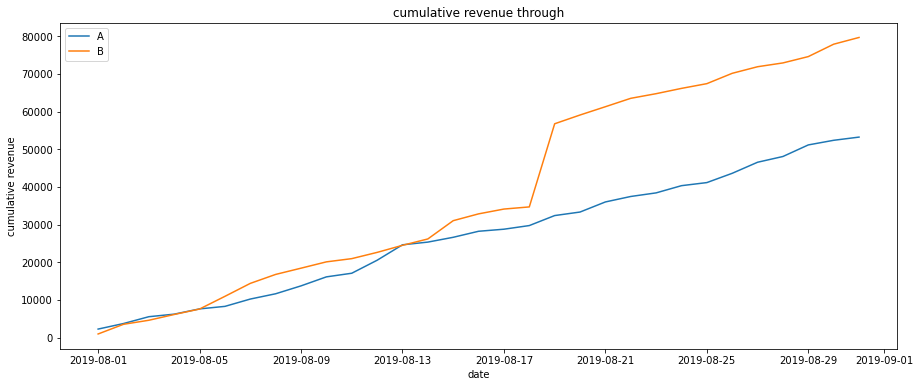

In [161]:
plt.rcParams["figure.figsize"] = (15,6)
plt.plot(cum_rev_a['date'], cum_rev_a['cumu_rev'], label='A')
plt.plot(cum_rev_b['date'], cum_rev_b['cumu_rev'], label='B')
plt.xlabel('date')
plt.ylabel('cumulative revenue')
plt.title('cumulative revenue through')
plt.legend()
plt.show()

Both groups have a steady rise through the tests. B seems to have a larger revenue during the beginning, but around the 18th of August, there was a big spike in graph B. That may do to a surge in the number of orders, or do to big and expensive orders.
I'll look in to it latter.

## Cumulative average order size

Now I'll fined the cumulative average purchase size.  
To do so, I'll group the number of orders form the order_df table by day, then merge the new tables with the table from the privies task.

In [162]:
order_by_day_a = orders_a.groupby('date', as_index = False).agg({'transactionId':'nunique'})
order_by_day_b = orders_b.groupby('date', as_index = False).agg({'transactionId':'nunique'})

In [163]:
cum_avg_order_a = cum_rev_a.merge(order_by_day_a, on = 'date', how = 'left')
cum_avg_order_b = cum_rev_b.merge(order_by_day_b, on = 'date', how = 'left')
cum_avg_order_a.head()

,date,revenue,cumu_rev,transactionId
0,2019-08-01,2266.6,2266.6,23
1,2019-08-02,1468.3,3734.9,19
2,2019-08-03,1815.2,5550.1,24
3,2019-08-04,675.5,6225.6,11
4,2019-08-05,1398.0,7623.6,22


In [164]:
cum_avg_order_b.head()

,date,revenue,cumu_rev,transactionId
0,2019-08-01,967.2,967.2,17
1,2019-08-02,2568.1,3535.3,23
2,2019-08-03,1071.6,4606.9,14
3,2019-08-04,1531.6,6138.5,14
4,2019-08-05,1449.3,7587.8,21


After that, I can create a column that contains the cumulative number of orders.   
Then, by dividing the cumulative revenue by the cumulative number of orders, I'll get the cumulative average order size.

In [165]:
cum_avg_order_a['cum_num_order'] = cum_avg_order_a['transactionId'].cumsum()
cum_avg_order_a['cum_avg_order'] = cum_avg_order_a['cumu_rev'] / cum_avg_order_a['cum_num_order']
cum_avg_order_a.head()

,date,revenue,cumu_rev,transactionId,cum_num_order,cum_avg_order
0,2019-08-01,2266.6,2266.6,23,23,98.547826
1,2019-08-02,1468.3,3734.9,19,42,88.926190
2,2019-08-03,1815.2,5550.1,24,66,84.092424
3,2019-08-04,675.5,6225.6,11,77,80.851948
4,2019-08-05,1398.0,7623.6,22,99,77.006061


In [166]:
cum_avg_order_b['cum_num_order'] = cum_avg_order_b['transactionId'].cumsum()
cum_avg_order_b['cum_avg_order'] = cum_avg_order_b['cumu_rev'] / cum_avg_order_b['cum_num_order']
cum_avg_order_b.head()

,date,revenue,cumu_rev,transactionId,cum_num_order,cum_avg_order
0,2019-08-01,967.2,967.2,17,17,56.894118
1,2019-08-02,2568.1,3535.3,23,40,88.382500
2,2019-08-03,1071.6,4606.9,14,54,85.312963
3,2019-08-04,1531.6,6138.5,14,68,90.272059
4,2019-08-05,1449.3,7587.8,21,89,85.256180


Now I can plot the graphs.

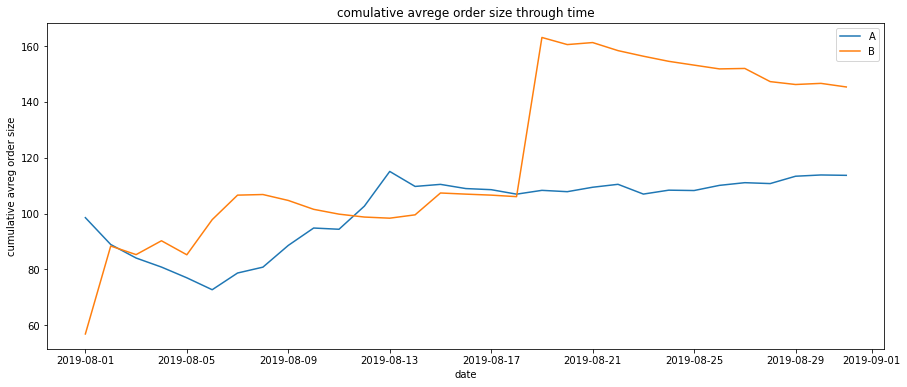

In [167]:
plt.rcParams["figure.figsize"] = (15,6)
plt.plot(cum_avg_order_a['date'], cum_avg_order_a['cum_avg_order'], label='A')
plt.plot(cum_avg_order_b['date'], cum_avg_order_b['cum_avg_order'], label='B')
plt.xlabel('date')
plt.ylabel('cumulative avreg order size')
plt.title('comulative avrege order size through time')
plt.legend()
plt.show()

We can see that graph B has become steady after the 17th and A after the 13th. graph A has stabilized and graph B is falling.
The big fall in the beginning for group A, and the 2 big surges for group B May be due to abnormal purchase sizes.  

## Relative difference in cumulative average order size

To fined the relative difference in average order size, first I need to merge the two tables together. 

In [168]:
merg_grp_cum = cum_avg_order_a.merge(cum_avg_order_b, left_on = 'date', right_on = 'date', how = 'left', suffixes=['A', 'B'])
merg_grp_cum.head()

,date,revenueA,cumu_revA,transactionIdA,cum_num_orderA,cum_avg_orderA,revenueB,cumu_revB,transactionIdB,cum_num_orderB,cum_avg_orderB
0,2019-08-01,2266.6,2266.6,23,23,98.547826,967.2,967.2,17,17,56.894118
1,2019-08-02,1468.3,3734.9,19,42,88.926190,2568.1,3535.3,23,40,88.382500
2,2019-08-03,1815.2,5550.1,24,66,84.092424,1071.6,4606.9,14,54,85.312963
3,2019-08-04,675.5,6225.6,11,77,80.851948,1531.6,6138.5,14,68,90.272059
4,2019-08-05,1398.0,7623.6,22,99,77.006061,1449.3,7587.8,21,89,85.256180


Now that I have merged the tables, I can create a graph that shows the relative difference in cumulative average order size.  
I'll do that by dividing the cumulative average order size of group B by A's cumulative average order size.

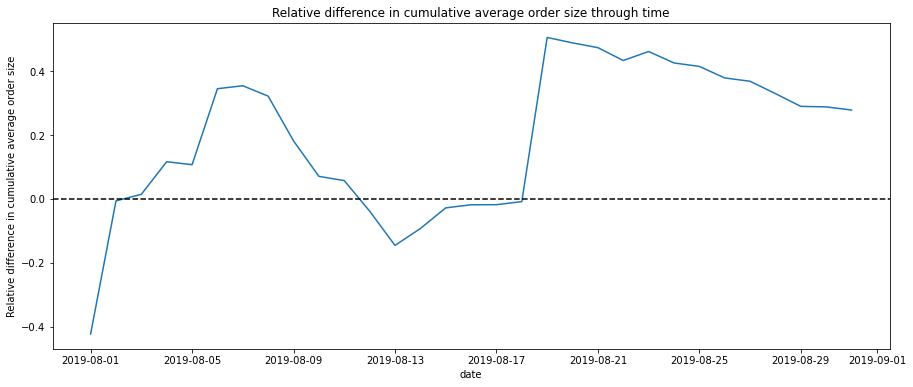

In [169]:
merg_grp_cum['rlv_def_cum_avg_ord'] = merg_grp_cum['cum_avg_orderB']/merg_grp_cum['cum_avg_orderA'] -1

plt.rcParams["figure.figsize"] = (15,6)
plt.plot(merg_grp_cum['date'], merg_grp_cum['rlv_def_cum_avg_ord'])
plt.axhline(y=0, color='black', linestyle='--')
plt.xlabel('date')
plt.ylabel('Relative difference in cumulative average order size')
plt.title('Relative difference in cumulative average order size through time')
plt.show()

It seems that there are some huge spikes, it means that without a doubt there are some big orders and outliers.  

## Group's conversion rate

I'll calculate each group's conversion rate from visits to orders each day.   
To do so, first I'll need to divide the visits_df column to groups, and merge the new tables with the groups tables. 

In [170]:
visits_df_a = visits_df[visits_df['group'] == 'A']
visits_df_b = visits_df[visits_df['group'] == 'B']

In [171]:
group_a = cum_avg_order_a.merge(visits_df_a, on = 'date', how = 'left')
group_b = cum_avg_order_b.merge(visits_df_b, on = 'date', how = 'left')

Now, for each table, I'll create a cum_visits column, that will contain the cumulative number of visits.

In [172]:
group_a['cum_visits'] = group_a['visits'].cumsum()
group_b['cum_visits'] = group_b['visits'].cumsum()

Now I can create the conversion rate column, by dividing the cumulative number of orders by the cumulative number of visits.

In [173]:
group_a['conversion_rate'] = group_a['cum_num_order'] / group_a['cum_visits']
group_b['conversion_rate'] = group_b['cum_num_order'] / group_b['cum_visits']

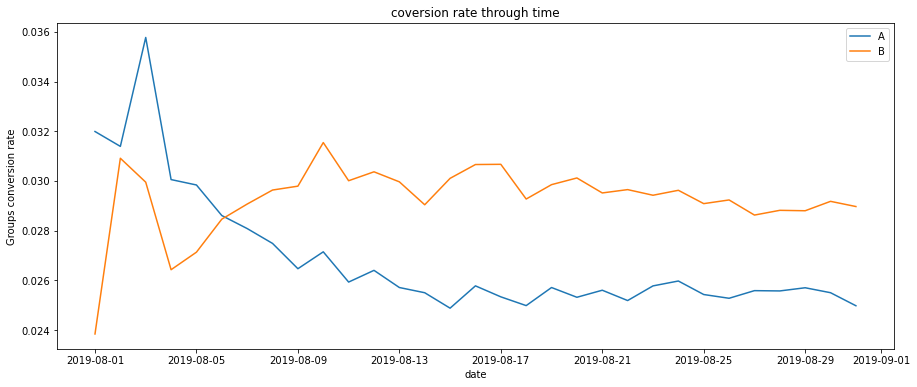

In [174]:
plt.rcParams["figure.figsize"] = (15,6)
plt.plot(group_a['date'], group_a['conversion_rate'], label='A')
plt.plot(group_b['date'], group_b['conversion_rate'], label='B')
plt.xlabel('date')
plt.ylabel('Groups conversion rate')
plt.title('coversion rate through time')
plt.legend()
plt.show()

Seems like both graphs in the beginning experience really big spikes in conversion rate, bot then stabilize after the 5th.  
B's conversion is around 3% conversion, and A's around 2.6%. after B's unstable spike, it rouse back will A got lower.

## Number of orders per user

Lets see a scatter plot that shows the number of orders per user. I'll group the number of orders by visitorId. 

In [175]:
num_ord_usr = orders_df.groupby('visitorId', as_index = False).agg({'transactionId':'nunique'})
num_ord_usr.columns = ['visitorId','num_orders']
num_ord_usr.head()

,visitorId,num_orders
0,5114589,1
1,6958315,1
2,11685486,1
3,39475350,1
4,47206413,1


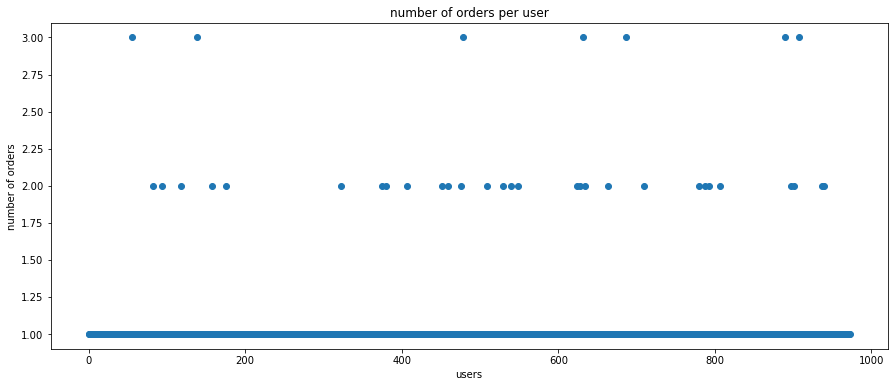

In [226]:
x_values = pd.Series(range(0,len(num_ord_usr)))
plt.scatter(x_values,num_ord_usr['num_orders'])
plt.xlabel('users')
plt.ylabel('number of orders')
plt.title('number of orders per user')
plt.show()

We see that the vast majority of users only make one order, then there are sum that make two orders and very few how make 3 orders.  
It's hard to say if I need to consider the small few that have made 3 orders.

## Percentiles for the number of orders

Using percentiles, I'll see if the visitors that made more then 1 order take a big percentage of the hole population.

In [177]:
np.percentile(num_ord_usr['num_orders'], [95,99])

array([1., 2.])

no more then 5% of users made more then 1 order, and no more then 1% made more then 2 orders.  
From this results, I'd say that 1 order should be the upper limit, and remove every thing above it. 

## Order prices

Lets find the order price. I can create a scatter plot, that will give me a better idea of the situation.

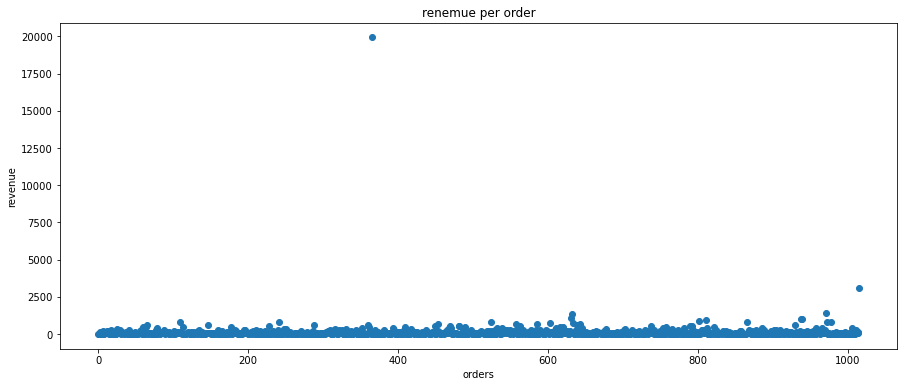

In [227]:
x_values = pd.Series(range(0,len(orders_df['revenue'])))
plt.scatter(x_values,orders_df['revenue'])
plt.xlabel('orders')
plt.ylabel('revenue')
plt.title('renemue per order')
plt.show()

Dos not seem like most orders pass the 2500.

## Percentiles of order prices

Using percentiles, I can see what prices are considered abnormal for an average order. 

In [179]:
np.percentile(orders_df['revenue'], [95,99])

array([414.275, 830.3  ])

5% of orders are more expensive then 415, and 1% are more expensive then 830. There is no need to consider prices that are more then 415, so we can take out the anomalies.

Lets see a scatter plot without the outliers.

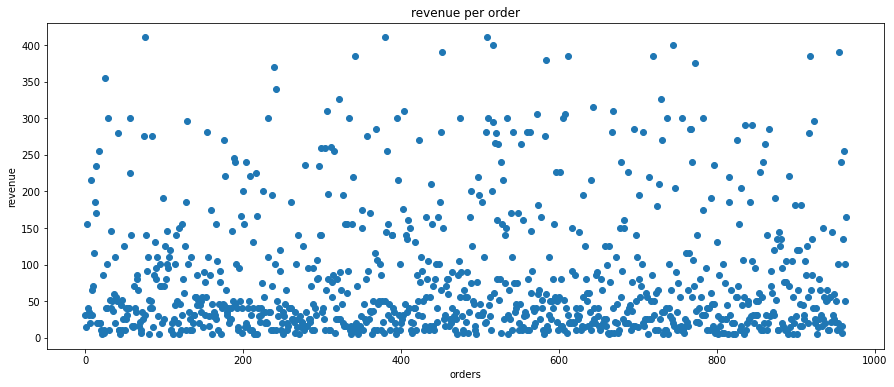

In [228]:
orders_df_no_anoma = orders_df[orders_df['revenue'] <= 415]

x_values = pd.Series(range(0,len(orders_df_no_anoma['revenue'])))
plt.scatter(x_values,orders_df_no_anoma['revenue'])
plt.xlabel('orders')
plt.ylabel('revenue')
plt.title('revenue per order')
plt.show()

This seems better. the orders are more scattered around, and it's hard to see if there are outliers. There is a higher concentration around 50$ but nothing to dramatic.

## Statistical significance of the difference in conversion - raw data

Lets see if there is statistical significance of difference in conversion in groups.  
To do that, first lets create a two samples that contains a list of the number of orders for each user in each group, and zeros for users how did not order anything. 

In [180]:
order_by_user_a = orders_df[orders_df['group'] == 'A'].groupby('visitorId', as_index = False).agg({'transactionId':'nunique'})
order_by_user_a.columns = ['user','orders']

In [181]:
order_by_user_b = orders_df[orders_df['group'] == 'B'].groupby('visitorId', as_index = False).agg({'transactionId':'nunique'})
order_by_user_b.columns = ['user','orders']

In [182]:
sample_a = pd.concat(
    [
        order_by_user_a['orders'],pd
        .Series(
            0, index=np
            .arange(visits_df[visits_df['group'] == 'A']['visits'].sum() - len(order_by_user_a['orders'])), name='orders'
        )
    ],axis=0
)

In [183]:
sample_b = pd.concat(
    [
        order_by_user_b['orders'],pd
        .Series(
            0, index=np
            .arange(visits_df[visits_df['group'] == 'B']['visits'].sum() - len(order_by_user_b['orders'])), name='orders'
        )
    ],axis=0
)

Now I'll create a function that will check if the samples have a normal distribution using the Shapiro method, and according to the result I will pass the samples in either the Mannwhitneyu method, or in the ttest method, if they have a normal distribution then ttest, otherwise Mannwhitneyu. By applying this function, I can see if there is a Statistical significance of the difference in conversion.

H0 : conversion in group A == conversion in group B   
H1 : conversion in group A != conversion in group B

I can see the method that is going to be used by crating a histogram. if the graphs wont be skewed, then the data has a normal distribution and I'll use the the ttest, otherwise we I'll use the Mannwhitneyu 

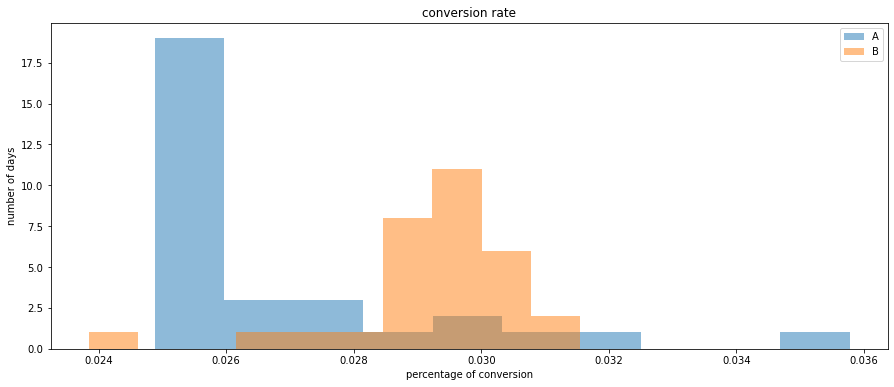

In [209]:
plt.hist(group_a['conversion_rate'], alpha=0.5, label='A')
plt.hist(group_b['conversion_rate'], alpha=0.5, label='B')
plt.legend(loc='upper right')
plt.xlabel('percentage of conversion')
plt.ylabel('number of days')
plt.title('conversion rate')
plt.show()

Mannwhitneyu it is

In [185]:
def testing_average(sample1,sample2,alpha=0.05):
    
    sample1=sample1.dropna()
    sample2=sample2.dropna()
    results1=st.shapiro(sample1)
    results2=st.shapiro(sample2)
    p1_norm = results1[1]
    p2_norm = results2[1]
    if ((p1_norm > alpha) and (p2_norm>alpha)):
        
        
        p_levene=st.levene(sample1, sample2)
        if p_levene<alpha:
           
            p_value=st.ttest_ind(sample1, sample2,equal_var=False)
        else:
            p_value=st.ttest_ind(sample1, sample2,equal_var=True) 
    else:
        p_value=st.mannwhitneyu(sample1, sample2)[1]
    print(p_value)
    if p_value<alpha:
        print('Reject H0')
    else:
        print('Fail to Reject H0')
    print("{0:.3f}".format(sample2.mean()/sample1.mean()-1))

In [186]:
testing_average(sample_a,sample_b,alpha=0.05)

0.011018084110014696
Reject H0
0.160


C:\programing files\lib\site-packages\scipy\stats\morestats.py:1760: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


If we are going according to the raw data, there is a statistically significant difference in conversion between the groups. And the relative gain of group B is 16%.

## Statistical significance of the difference in average order size - raw data

Lets fined the Statistical significance of the difference in average order size, by doing the same thing as before bot for revenue per order.

In [187]:
avg_orders_revenue_a = orders_a['revenue']
avg_orders_revenue_b = orders_b['revenue']

Using the function from before, I'm going to see if there is statistical significance.  

H0: average order size in group A == average order size in group B.  
H1: average order size in group A != average order size in group B

lets see what method I'm going to use.

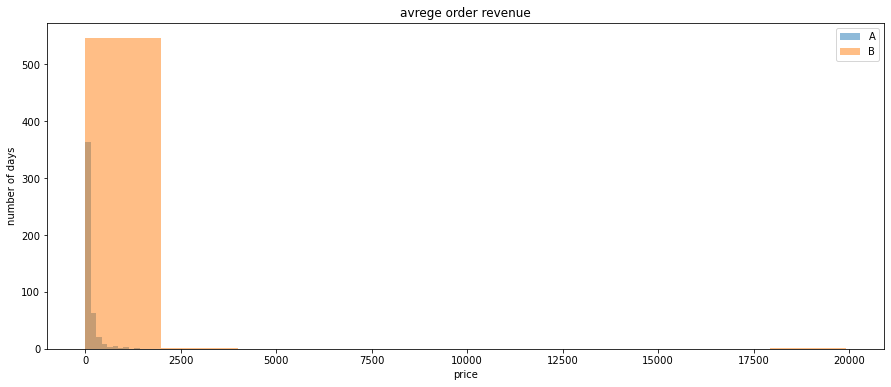

In [201]:
plt.hist(orders_a['revenue'], alpha=0.5, label='A')
plt.hist(orders_b['revenue'], alpha=0.5, label='B')
plt.legend(loc='upper right')
plt.xlabel('price')
plt.ylabel('number of days')
plt.title('avrege order revenue')
plt.show()

Mannwhitneyu again 

In [202]:
testing_average(avg_orders_revenue_a,avg_orders_revenue_b,alpha=0.05)

0.8622329690015668
Fail to Reject H0
0.278


According to the raw data, there is no Statistical significance of the difference in average order size. Nonetheless, group B's average order size is 27.8% bigger then group A's.

 ## Statistical significance of the difference in conversion - filtered data

Now I'm going find if there is a Statistical significance of the difference in conversion, but this time I'm going to use filtered data. This is so I can see how much the abnormalities skew the data.  
To create the filtered data, first I need to define the anomalies. According to the scatter plot and the percentile, I'd say to define every thing above one order, as an anomaly. 

In [189]:
order_num_anomaly = (
    pd.concat(
    [
        order_by_user_a[order_by_user_a['orders'] > 1]['user'], order_by_user_b[order_by_user_b['orders'] > 1]['user']
    ], axis = 0
)
                    )

In [190]:
sample_a_filtered = pd.concat(
    [order_by_user_a[np.logical_not(order_by_user_a['user'].isin(order_num_anomaly))]['orders'],pd
        .Series(
            0, index=np
            .arange(visits_df[visits_df['group'] == 'A']['visits'].sum() - len(order_by_user_a['orders'])), name='orders'
        )
    ],axis=0
) 

In [191]:
sample_b_filtered = pd.concat(
    [order_by_user_b[np.logical_not(order_by_user_b['user'].isin(order_num_anomaly))]['orders'],pd
        .Series(
            0, index=np
            .arange(visits_df[visits_df['group'] == 'B']['visits'].sum() - len(order_by_user_b['orders'])), name='orders'
        )
    ],axis=0
) 

H0 : conversion in group A == conversion in group B   
H1 : conversion in group A != conversion in group B

to fined out, what kind of method where using, I have to create the filtered table.

In [215]:
visitor_fil = orders_df.groupby('visitorId', as_index = False).agg({'transactionId':'nunique'})
visitor_fil = visitor_fil[visitor_fil['transactionId'] == 1]
fil = visitor_fil['visitorId']
df_fil = orders_df[orders_df['visitorId'].isin(fil)]

In [219]:
fil_a = df_fil[df_fil['group'] == 'A']
fil_b = df_fil[df_fil['group'] == 'B']

order_by_day_a_fil = fil_a.groupby('date', as_index = False).agg({'transactionId':'nunique'})
order_by_day_b_fil = fil_b.groupby('date', as_index = False).agg({'transactionId':'nunique'})

cum_rev_a_fil = fil_a.groupby('date', as_index = False).agg({'revenue':'sum'})
cum_rev_b_fil = fil_b.groupby('date', as_index = False).agg({'revenue':'sum'})

cum_rev_a_fil['cumu_rev'] = cum_rev_a_fil['revenue'].cumsum()
cum_rev_b_fil['cumu_rev'] = cum_rev_b_fil['revenue'].cumsum()

cum_avg_order_a_fil = cum_rev_a_fil.merge(order_by_day_a_fil, on = 'date', how = 'left')
cum_avg_order_b_fil = cum_rev_b_fil.merge(order_by_day_b_fil, on = 'date', how = 'left')

cum_avg_order_a_fil['cum_num_order'] = cum_avg_order_a_fil['transactionId'].cumsum()
cum_avg_order_a_fil['cum_avg_order'] = cum_avg_order_a_fil['cumu_rev'] / cum_avg_order_a_fil['cum_num_order']

cum_avg_order_b_fil['cum_num_order'] = cum_avg_order_b_fil['transactionId'].cumsum()
cum_avg_order_b_fil['cum_avg_order'] = cum_avg_order_b_fil['cumu_rev'] / cum_avg_order_b_fil['cum_num_order']

group_a_fil = cum_avg_order_a_fil.merge(visits_df_a, on = 'date', how = 'left')
group_b_fil = cum_avg_order_b_fil.merge(visits_df_b, on = 'date', how = 'left')

group_a_fil['cum_visits'] = group_a_fil['visits'].cumsum()
group_b_fil['cum_visits'] = group_b_fil['visits'].cumsum()

group_a_fil['conversion_rate'] = group_a_fil['cum_num_order'] / group_a_fil['cum_visits']
group_b_fil['conversion_rate'] = group_b_fil['cum_num_order'] / group_b_fil['cum_visits']

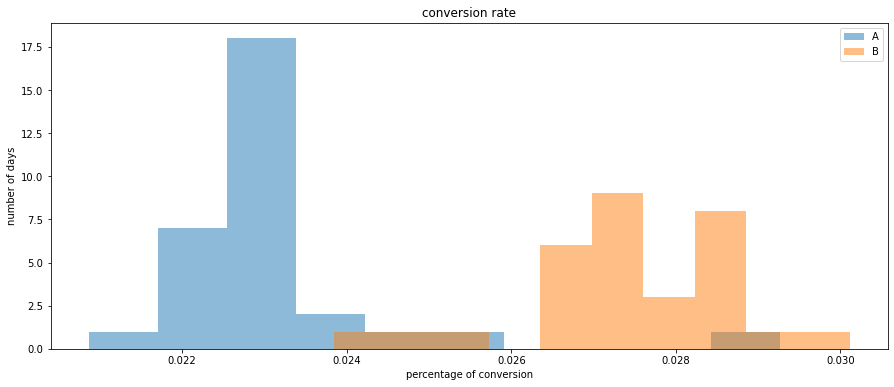

In [220]:
plt.hist(group_a_fil['conversion_rate'], alpha=0.5, label='A')
plt.hist(group_b_fil['conversion_rate'], alpha=0.5, label='B')
plt.legend(loc='upper right')
plt.xlabel('percentage of conversion')
plt.ylabel('number of days')
plt.title('conversion rate')
plt.show()

Mannwhitneyu

In [192]:
testing_average(sample_a_filtered,sample_b_filtered,alpha=0.05)

0.009388750157649953
Reject H0
0.183


Just like before, it still seems that there is a Statistical significance of the difference in conversion, and now group B has  18% higher conversion rate then group A.

## Statistical significance of the difference in average order size - filtered data 

Lets create a filter for order size, every order above 400$ is abnormal.

In [222]:
order_size_anomaly = orders_df[orders_df['revenue'] > 415]['visitorId']

In [223]:
avg_orders_revenue_a_filtered = orders_a[np.logical_not(orders_a['visitorId'].isin(order_size_anomaly))]['revenue']
avg_orders_revenue_b_filtered = orders_b[np.logical_not(orders_b['visitorId'].isin(order_size_anomaly))]['revenue']

Using the function from before, I'm going to see if there is statistical significance.  

H0: average order size in group A == average order size in group B.  
H1: average order size in group A != average order size in group B

lets see what method I'm going to use

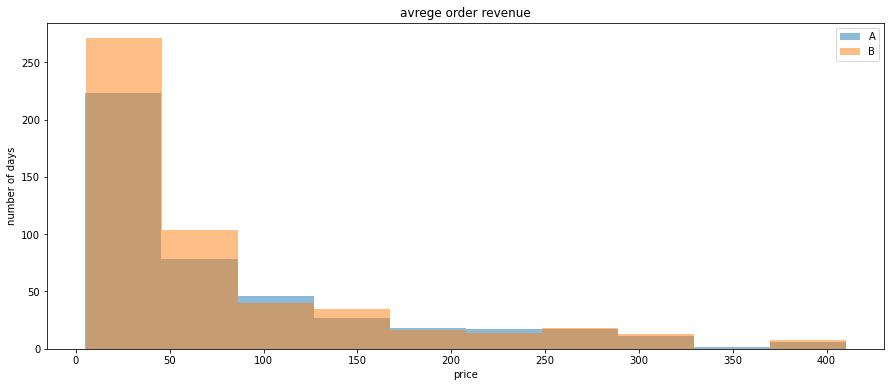

In [224]:
plt.hist(avg_orders_revenue_a_filtered, alpha=0.5, label='A')
plt.hist(avg_orders_revenue_b_filtered, alpha=0.5, label='B')
plt.legend(loc='upper right')
plt.xlabel('price')
plt.ylabel('number of days')
plt.title('avrege order revenue')
plt.show()

Mannwhitneyu for the win

In [225]:
testing_average(avg_orders_revenue_a_filtered,avg_orders_revenue_b_filtered,alpha=0.05)

0.7757659942554258
Fail to Reject H0
-0.052


Just like before we see there's no statistical significance of the difference in average order size, but now we see that the average order size of group B is 5.2% smaller then group A.

# Summary

1. In the pre-process stage:
    1. I saw that the date and group columns in the orders and visitors tables needed to have their data type changed.  
       First I changed the data type of the date column, in both orders and visits tables, to datetime.    
       then I changed the group data type in to categories.  
    1. I saw that I needed to split the columns and data of hypothesis table.  
       Using the sep in the read_csv(), I separated the columns in the hypothesis table in to a readable format.  
    1. I saw that the hypothesis table contained upper case letters.  
       I changed the columns names to lower case using columns.str.lower().
    1. There were users that were in groups A and B.  
       To identify them I created a table that groups the number of unique groups by visitorsId.  
       Taking the two_groups_check I created before, I removed all the visitors that are in both groups.
       Then I left merged the table with the orders_df column, so that the orders table will get rid of all the unwanted data.  
1. In the prioritizing stag:
    1. I created an ICE column in the hypothesis table, by multiplying impact with confidence,
       and dividing the result by efforts.  
    1. To find the RICE of a hypothesis, is the same as finding the ICE,  
       the difference is that we also multiply the ICE with reach column.
1. In the A/B test analysis:
    1. I graphed cumulative revenue by group, by dividing the orders table to two tables for each group.  
       From each of the new tables, I grouped the sum of revenue by day.
       Then using cumsum(), I created a column that contains the cumulative revenue.  
       Using the new columns, I plotted the cumulative revenue graphs.  
    1. I found the cumulative average purchase size,  
       by grouping the number of orders form the order_df table by day,  
       then merging the new tables with the table from the privies task.
       After that, I created a column that contains the cumulative number of orders.  
       Then, by dividing the cumulative revenue by the cumulative number of orders, I got the cumulative average order size.
       Then I plotted the graphs.  
    1. To fined the relative difference in average order size, first I had to merge the two tables together.  
       After merging the tables, I created a graph that shows the relative difference in cumulative average order size.  
       I did that by dividing the cumulative average order size of group B by A's cumulative average order size.  
    1. I calculated each group's conversion rate from visits to orders each day.  
       I divided the visits_df column to groups, and merged the new tables with the groups tables.  
       After merging the new columns, I created the conversion column by dividing the number of orders a day,  
       by the number of visits per day.  
    1. I created scatter plot that shows the number of orders per user.  
       I grouped the number of orders by visitorId to do so.  
    1. Using percentiles, I saw if the visitors that made more then 1 order took a big percentage of the hole population.  
    1. I found the order price, by creating a scatter plot, that  gave me a better idea of the situation.  
    1. Using percentiles, I saw what prices are considered abnormal for an average order.  
    1. I wanted to see if there is statistical significance of difference in conversion in groups using raw data.  
       To do that, first I created two samples that contain a list of the number of orders for each user in each group,  
       and zeros for users how did not order anything.  
       Then I created a function that checked if the samples have a normal distribution,  
       and according to the result I passed the samples in either the Mannwhitneyu method,  
       or in the ttest method.  
       By applying this function, I saw if there is a Statistical significance of the difference in conversion.
    1. I found the Statistical significance of the difference in average order size in the raw data,  
       by doing the same thing as before, but for revenue per order.  
       Using the function from before, I got to see if there is statistical significance.
    1. I found if there is a Statistical significance of the difference in conversion, but this time I used filtered data.  
       This was so I could see how much the abnormalities skewed the data.  
       To create the filtered data, first I had to define the anomalies. According to the scatter plot and the percentile,  
       I defined every thing above one order, as an anomaly.
    1. I created a filtered data for order size, and determined every order above 400$ as abnormal, and repeated the process.

## Conclusion

From what I can see from the data, it seems that the order size did not change to much between the groups.  
When it came to conversion id did seem that group B has the advantage on group A.  
because of this fact, I think that the should end and declare group B more optimal.